In [103]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer


df = pd.read_csv("OpenSSH_2k.log_structured.csv")
print(df.head())
print(df.info())


   LineId Date  Day      Time Component    Pid  \
0       1  Dec   10  06:55:46     LabSZ  24200   
1       2  Dec   10  06:55:46     LabSZ  24200   
2       3  Dec   10  06:55:46     LabSZ  24200   
3       4  Dec   10  06:55:46     LabSZ  24200   
4       5  Dec   10  06:55:46     LabSZ  24200   

                                             Content EventId  \
0  reverse mapping checking getaddrinfo for ns.ma...     E27   
1         Invalid user webmaster from 173.234.31.186     E13   
2  input_userauth_request: invalid user webmaster...     E12   
3      pam_unix(sshd:auth): check pass; user unknown     E21   
4  pam_unix(sshd:auth): authentication failure; l...     E19   

                                       EventTemplate  
0  reverse mapping checking getaddrinfo for <*> [...  
1                          Invalid user <*> from <*>  
2  input_userauth_request: invalid user <*> [prea...  
3      pam_unix(sshd:auth): check pass; user unknown  
4  pam_unix(sshd:auth): authentication 

**Descriptive analysis**

Columns: ['LineId', 'Date', 'Day', 'Time', 'Component', 'Pid', 'Content', 'EventId', 'EventTemplate']

Data types:
 LineId            int64
Date             object
Day               int64
Time             object
Component        object
Pid               int64
Content          object
EventId          object
EventTemplate    object
dtype: object

Missing values (%):
 LineId           0.0
Date             0.0
Day              0.0
Time             0.0
Component        0.0
Pid              0.0
Content          0.0
EventId          0.0
EventTemplate    0.0
dtype: float64

Top EventId values:
 EventId
E24    413
E20    384
E9     383
E10    135
E21    135
E13    113
E12    113
E19    110
E27     85
E7      45
Name: count, dtype: int64

Sample log lines:


0    reverse mapping checking getaddrinfo for ns.ma...
1           Invalid user webmaster from 173.234.31.186
2    input_userauth_request: invalid user webmaster...
3        pam_unix(sshd:auth): check pass; user unknown
4    pam_unix(sshd:auth): authentication failure; l...
Name: Content, dtype: object

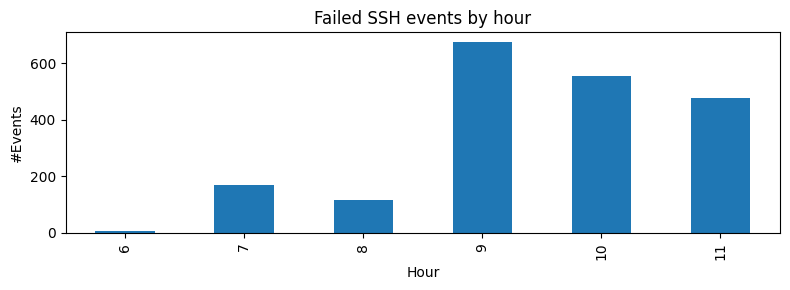


Sample of data with Hour column:


,EventId,Content,Hour
0,E27,reverse mapping checking getaddrinfo for ns.ma...,6
1,E13,Invalid user webmaster from 173.234.31.186,6
2,E12,input_userauth_request: invalid user webmaster...,6
3,E21,pam_unix(sshd:auth): check pass; user unknown,6
4,E19,pam_unix(sshd:auth): authentication failure; l...,6
5,E10,Failed password for invalid user webmaster fro...,6
6,E2,Connection closed by 173.234.31.186 [preauth],6
7,E2,Connection closed by 212.47.254.145 [preauth],7
8,E13,Invalid user test9 from 52.80.34.196,7
9,E12,input_userauth_request: invalid user test9 [pr...,7


In [104]:

# --- Basic stats ---
print("Columns:", list(df.columns))
print("\nData types:\n", df.dtypes)
print("\nMissing values (%):\n", (df.isna().mean()*100).round(2).sort_values(ascending=False))

print("\nTop EventId values:\n", df["EventId"].value_counts().head(10))
print("\nSample log lines:")
display(df["Content"].head(5))

# --- Some data on Time column ---
if "Time" in df.columns:
    df["Time"] = pd.to_datetime(df["Time"], format="%H:%M:%S", errors="coerce")
    df["Hour"] = df["Time"].dt.hour
    ax = df["Hour"].value_counts().sort_index().plot(kind="bar", figsize=(8,3))
    ax.set_title("Failed SSH events by hour")
    ax.set_xlabel("Hour")
    ax.set_ylabel("#Events")
    plt.tight_layout()
    plt.show()

# --- Features: conn_per_hour (provisoire, on la refera après) ---
if "Hour" in df.columns:
    df["Hour"] = df["Hour"].fillna(-1).astype(int)

print("\nSample of data with Hour column:")
if "Hour" in df.columns:
    display(df[["EventId","Content","Hour"]].head(10))


**Implementation of the Necessary Preprocessing**

In [105]:
# %%
import re
import pandas as pd
import numpy as np

# 1) Heure à partir de Time si présent
if "Time" in df.columns:
    df["Time"] = pd.to_datetime(df["Time"], format="%H:%M:%S", errors="coerce")
    df["Hour"] = df["Time"].dt.hour
else:
    if "Hour" not in df.columns:
        df["Hour"] = -1

# 2) ip à partir du texte Content (si pas déjà fait)
#    (On récupère une adresse IPv4 dans le log)
df["ip"] = df["Content"].str.extract(r'(\d{1,3}(?:\.\d{1,3}){3})')

# 3) user à partir du texte Content (approximation)
#    On cherche un motif "user xxx" ou "invalid user xxx"
user_regex = r"(?:invalid user|user)\s+([^\s]+)"
df["user"] = df["Content"].str.extract(user_regex)

# 4) port à partir du texte Content
port_regex = r"port\s+(\d+)"
df["port"] = df["Content"].str.extract(port_regex)
df["port"] = pd.to_numeric(df["port"], errors="coerce")

# 5) preauth (booléen)
df["preauth"] = df["Content"].str.contains("preauth", case=False, na=False)

# 6) conn_per_hour : nombre de connexions par ip et par heure
if "Hour" in df.columns:
    df["Hour"] = df["Hour"].fillna(-1).astype(int)
    df["conn_per_hour"] = df.groupby(["ip", "Hour"])["EventId"].transform("count")
else:
    df["conn_per_hour"] = df["EventId"].groupby(df["ip"]).transform("count")

# 7) création de connection_type (N vs S)
normal_events = {"E1", "E2", "E22", "E23", "E24", "E25", "E26"}
df["connection_type"] = df["EventId"].apply(
    lambda x: "N" if str(x) in normal_events else "S"
)

# 8) on garde un sous-ensemble de colonnes utiles
cols_to_keep = ["ip", "user", "port", "preauth", "Hour", "conn_per_hour",
                "connection_type", "Content"]
df = df[[c for c in cols_to_keep if c in df.columns]].copy()

print(df.head(10))
print("\nconnection_type distribution:\n", df["connection_type"].value_counts())


               ip       user     port  preauth  Hour  conn_per_hour  \
0  173.234.31.186        NaN      NaN    False     6            5.0   
1  173.234.31.186  webmaster      NaN    False     6            5.0   
2             NaN  webmaster      NaN     True     6            NaN   
3             NaN    unknown      NaN    False     6            NaN   
4  173.234.31.186        NaN      NaN    False     6            5.0   
5  173.234.31.186  webmaster  38926.0    False     6            5.0   
6  173.234.31.186        NaN      NaN     True     6            5.0   
7  212.47.254.145        NaN      NaN     True     7            1.0   
8    52.80.34.196      test9      NaN    False     7            6.0   
9             NaN      test9      NaN     True     7            NaN   

  connection_type                                            Content  
0               S  reverse mapping checking getaddrinfo for ns.ma...  
1               S         Invalid user webmaster from 173.234.31.186  
2    

#Problematique

Chaques jours, les systèmes informatiques enregistre de nombreuses connexion et stockent les informations les concernant dans des journaux que l'on appel "Log". Certaines de ces connexions peuvent correspondre à des tentatives d'accès non autorisées, et les annalyser peut donc permettre de renforcer la sécurité des systèmes pour detecter les comportements suspects.

Dans ce projet, nous allons donc analyser des logs d'authentification SSH afin de détecter des activités anormales, comm les tentatices répétées de connexion.

Notre jeu de données contient de nombreuses informations qui ne nous serons pas utile comme le Pid (inutile car toutes les connexions ont été enregistrées sur la meme machine) et dont nous nous sommes donc débarassé. La colonne "Content" contenait quand à elle de nombreuses informations mais innexploitable car sous forme de texte, nous l'avons donc éclatée en plusieurs colonnes comme "IP". Enfin nous avons calculer le nombre de connexion d'un Ip par heure pour reperer les tentatives repétées et nous avons classifier les differents event (type d'échec ou de réussite de connexion) en deux categorie Suspect "S" ou Normal "N".


**Selection and Implementation of a Baseline Model**

Binary baseline (Normal vs Suspect)

=== Binary Classification (Normal vs Suspect) — avec ip + user ===
              precision    recall  f1-score   support

           N      1.000     1.000     1.000        92
           S      1.000     1.000     1.000       308

    accuracy                          1.000       400
   macro avg      1.000     1.000     1.000       400
weighted avg      1.000     1.000     1.000       400



/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


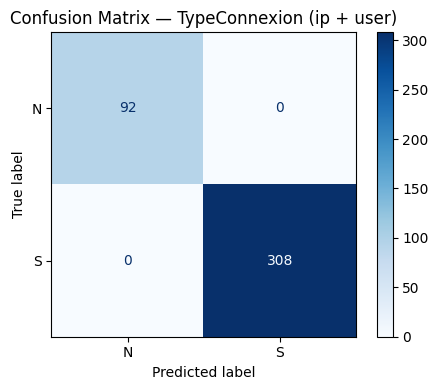

In [106]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

y_bin = df["connection_type"]
X_bin = df.drop(columns=["connection_type", "Content"])

num_cols  = ["port", "Hour", "conn_per_hour"]
bool_cols = ["preauth"]
cat_cols  = ["ip", "user"]

# --- Imputer uniquement sur les colonnes numériques ---
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("bool", "passthrough", bool_cols),  # <- plus d'imputer ici
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=500))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("=== Binary Classification (Normal vs Suspect) — avec ip + user ===")
print(classification_report(y_test, y_pred, digits=3))

fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix — TypeConnexion (ip + user)")
plt.tight_layout()
plt.show()


Notre model est trop parfais: aucun faux negatif ou  faux positif, il doit y avoir une variable trop corrélée a connexion type, ce qui donne directement la réponse au model et l'empèche d'apprendre. C'est tres probablement "ip": les ips de notre réseau sont considérées comme normale et les autres comme suspectes. Verifions ça, en regardant si certaines ips ont 100% N et d'autres 100% S. Si c'est le cas nous allons enlever IP des colonnes a utiliser pour predire connexion type

In [107]:
print(df.groupby(["ip","connection_type"]).size().head(50))


ip               connection_type
1.237.174.253    N                    3
103.207.39.16    N                    3
                 S                    9
103.207.39.165   N                    1
                 S                    4
103.207.39.212   N                    3
                 S                    9
103.99.0.122     S                  172
104.192.3.34     N                    2
                 S                    5
106.5.5.195      S                    4
112.95.230.3     N                   26
                 S                   54
119.137.62.142   N                    2
119.4.203.64     S                    9
123.235.32.19    N                    7
                 S                   15
173.234.31.186   N                    2
                 S                    8
175.102.13.6     N                    1
                 S                    3
177.79.82.136    S                    1
181.214.87.4     N                    1
                 S                    3
183.136

Certaines IP apparaissent uniquement en S (ex : 103.99.0.122 → 172 fois S) et certaines IP apparaissent quasiment toujours dans la même classe

Le modèle a donc appris :
“Si IP = X → répondre S. Si IP = Y → répondre N.”

recomençons sans cette colonne

=== Binary Classification (Normal vs Suspect) — sans ip, avec user ===
              precision    recall  f1-score   support

           N      0.989     1.000     0.995        92
           S      1.000     0.997     0.998       308

    accuracy                          0.998       400
   macro avg      0.995     0.998     0.996       400
weighted avg      0.998     0.998     0.998       400



/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


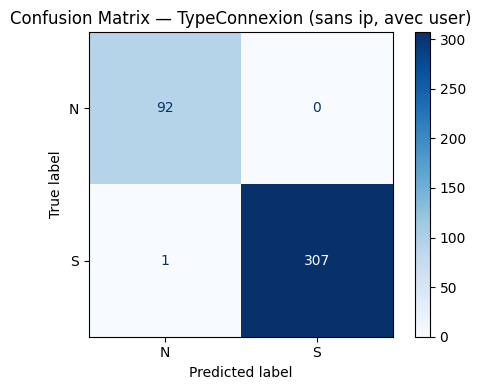

In [108]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

y_bin = df["connection_type"]
X_bin = df.drop(columns=["connection_type", "Content", "ip"])

num_cols  = ["port", "Hour", "conn_per_hour"]
bool_cols = ["preauth"]
cat_cols  = ["user"]

# --- on traite les NaN uniquement dans les colonnes numériques ---
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("bool", "passthrough", bool_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=500))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("=== Binary Classification (Normal vs Suspect) — sans ip, avec user ===")
print(classification_report(y_test, y_pred, digits=3))

fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix — TypeConnexion (sans ip, avec user)")
plt.tight_layout()
plt.show()


Notre model est un peu plus réaliste mais il reste tres facile a prédire, surment également grace a user (user = "root" ou "admin": souven t suspect, user = "unknown": suspect, user = "sysadmin" ou "service": normal), enlevons également cette colonne

=== Binary Classification (Normal vs Suspect) — sans ip ni user ===
              precision    recall  f1-score   support

           N      0.763     0.946     0.845        92
           S      0.983     0.912     0.946       308

    accuracy                          0.920       400
   macro avg      0.873     0.929     0.895       400
weighted avg      0.932     0.920     0.923       400



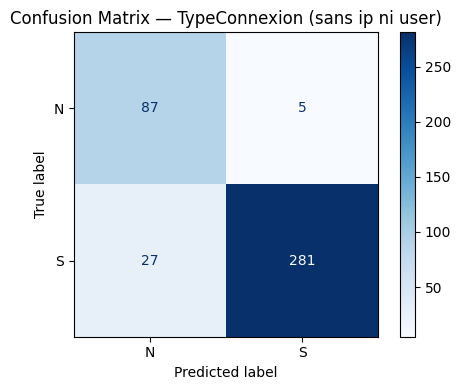

In [109]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

y_bin = df["connection_type"]
X_bin = df.drop(columns=["connection_type", "Content", "ip", "user"])

num_cols  = ["port", "Hour", "conn_per_hour"]
bool_cols = ["preauth"]

# on gère les NaN uniquement dans les colonnes numériques
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("bool", "passthrough", bool_cols),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=500))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("=== Binary Classification (Normal vs Suspect) — sans ip ni user ===")
print(classification_report(y_test, y_pred, digits=3))

fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix — TypeConnexion (sans ip ni user)")
plt.tight_layout()
plt.show()


maintenant notre model est beaucoup plus réaliste

Multiclass baseline (FailureType)

=== Classification report — FailureType (baseline) ===
                   precision    recall  f1-score   support

Connection closed       0.00      0.00      0.00         7
     Disconnected       0.79      0.99      0.88        94
  Failed password       0.80      0.05      0.10        77
     Invalid user       0.00      0.00      0.00        73
            Other       0.54      0.99      0.70       149

         accuracy                           0.61       400
        macro avg       0.42      0.41      0.33       400
     weighted avg       0.54      0.61      0.48       400



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


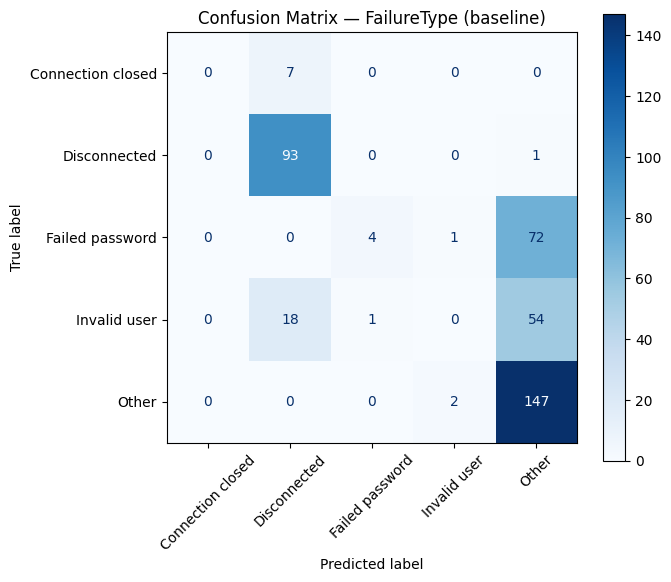

In [110]:
# %%
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# 1. Labels à partir de Content
def detect_failure_type(text):
    t = str(text).lower()
    if "invalid user" in t:      return "Invalid user"
    if "failed password" in t:   return "Failed password"
    if "connection closed" in t: return "Connection closed"
    if "disconnect" in t:        return "Disconnected"
    if "error" in t:             return "Other error"
    return "Other"

df["FailureType"] = df["Content"].apply(detect_failure_type)

# 2. Features pour FailureType
X = df[["port", "Hour", "conn_per_hour", "preauth"]].copy()
y = df["FailureType"]

num_cols  = ["port", "Hour", "conn_per_hour"]
bool_cols = ["preauth"]

# pipeline numérique : imputer puis scaler
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("bool", "passthrough", bool_cols),
    ]
)

clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LinearSVC())
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.20, random_state=42
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("=== Classification report — FailureType (baseline) ===")
print(classification_report(y_test, y_pred))

fig, ax = plt.subplots(figsize=(7,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues", xticks_rotation=45)
ax.set_title("Confusion Matrix — FailureType (baseline)")
plt.tight_layout()
plt.show()


notre model est assez precis, on arrive a predire la nature de l'incident uniquement a partir de donnée de base, meme si certaines catégorie sont assez evidentes comme connection close et disconnected qui peuvent etre facilement deduites de preaut ou invalid user de user, si on retire user nos données deviennent un peu plus interessantes

=== Classification report — FailureType (avec connection_type) ===


                   precision    recall  f1-score   support

Connection closed       0.00      0.00      0.00         7
     Disconnected       0.92      0.88      0.90        94
  Failed password       0.80      0.05      0.10        77
     Invalid user       0.62      0.41      0.50        73
            Other       0.55      0.95      0.70       149

         accuracy                           0.65       400
        macro avg       0.58      0.46      0.44       400
     weighted avg       0.69      0.65      0.58       400



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


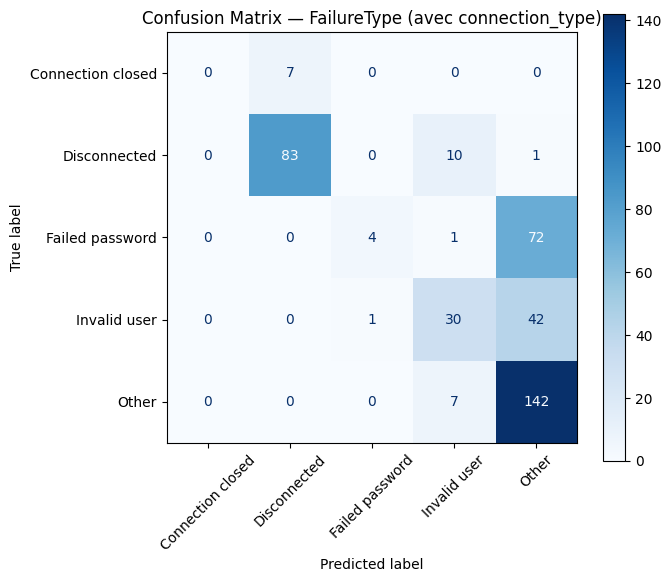

In [111]:
# %%
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# On réutilise FailureType
df["FailureType"] = df["Content"].apply(detect_failure_type)

# Ici on ajoute la variable connection_type comme feature
X = df[["port", "Hour", "conn_per_hour", "preauth", "connection_type"]].copy()
y = df["FailureType"]

num_cols  = ["port", "Hour", "conn_per_hour"]
bool_cols = ["preauth"]
cat_cols  = ["connection_type"]

# pipeline numérique : imputer puis scaler
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("bool", "passthrough", bool_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

clf2 = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LinearSVC())
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.20, random_state=42
)

clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)

print("=== Classification report — FailureType (avec connection_type) ===")
print(classification_report(y_test, y_pred))

fig, ax = plt.subplots(figsize=(7,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues", xticks_rotation=45)
ax.set_title("Confusion Matrix — FailureType (avec connection_type)")
plt.tight_layout()
plt.show()


On a plus que la classe other qui a un recall de 100% ce qui rend notre model plus interressant a improuver

##GRID SEARCH

reprenons notre linear svm avec grid search pour essayer d'ameliorer notre model

/home/codespace/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being s

Best params: {'clf__C': 10, 'clf__loss': 'squared_hinge'}
=== Classification report AFTER Grid Search — FailureType ===
                   precision    recall  f1-score   support

Connection closed       0.00      0.00      0.00         7
     Disconnected       0.92      0.88      0.90        94
  Failed password       0.80      0.05      0.10        77
     Invalid user       0.62      0.41      0.50        73
            Other       0.55      0.95      0.70       149

         accuracy                           0.65       400
        macro avg       0.58      0.46      0.44       400
     weighted avg       0.69      0.65      0.58       400



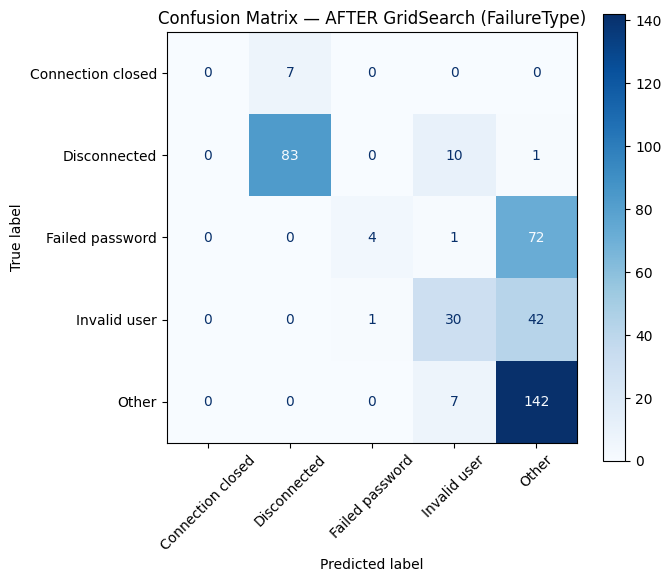

In [112]:
# %%
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Features pour FailureType
X = df[["port", "Hour", "conn_per_hour", "preauth", "connection_type"]].copy()
y = df["FailureType"]

num_cols  = ["port", "Hour", "conn_per_hour"]
bool_cols = ["preauth"]
cat_cols  = ["connection_type"]

# pipeline numérique : imputer puis scaler
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_cols),
    ("bool", "passthrough", bool_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

clf_base = Pipeline([
    ("preprocess", preprocessor),
    ("clf", LinearSVC(max_iter=5000))
])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.20, random_state=42
)

param_grid = {
    "clf__C": [0.1, 1, 10],
    "clf__loss": ["hinge", "squared_hinge"]
}

grid = GridSearchCV(
    clf_base,
    param_grid=param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)

y_pred = grid.predict(X_test)

print("=== Classification report AFTER Grid Search — FailureType ===")
print(classification_report(y_test, y_pred))

fig, ax = plt.subplots(figsize=(7,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues", xticks_rotation=45)
ax.set_title("Confusion Matrix — AFTER GridSearch (FailureType)")
plt.tight_layout()
plt.show()


Le grid search n'a pas permis d'ameliorer notre model. Il peut y avoir plusieurs raisons:
-le dataset est petit, déséquilibré, et avec très peu de variété lexicale:
-Le modèle est déjà “en plateau” (meilleure performance deja atteinte) : il ne peut pas mieux apprendre que ce qui est présent dans les données

Améliorer l’algorithme ne change rien si l’information dans les données ne permet pas de mieux séparer les classes.

En effet la plupart des classes sont deja tres bien apprise, la seule qui a plus de mal est invalid user, qui est difficile a apprendre sans user


Essaions le grid search sur notre model de prediction de connexion type, pour voir si ce model peut etre amelioré

Meilleurs hyperparamètres : {'clf__C': 0.01, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Meilleur score (cv f1_macro) : 0.88852489728287

=== AFTER GRID SEARCH — connection_type ===
              precision    recall  f1-score   support

           N      0.773     1.000     0.872        92
           S      1.000     0.912     0.954       308

    accuracy                          0.932       400
   macro avg      0.887     0.956     0.913       400
weighted avg      0.948     0.932     0.935       400



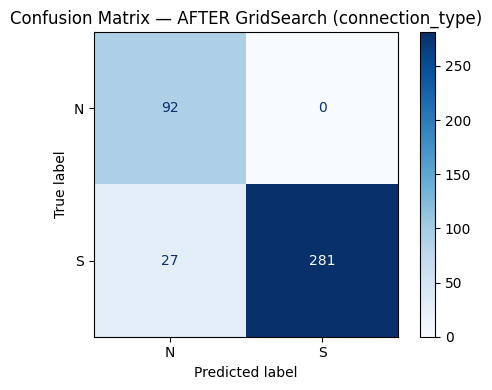

In [113]:
# %%
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

y_bin = df["connection_type"]
X_bin = df.drop(columns=["connection_type", "Content", "ip", "user"])

num_cols  = ["port", "Hour", "conn_per_hour"]
bool_cols = ["preauth"]

# pipeline numérique : imputer puis scaler
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

preprocess_bin = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("bool", "passthrough", bool_cols),
    ]
)

log_reg = Pipeline(steps=[
    ("preprocess", preprocess_bin),
    ("clf", LogisticRegression(max_iter=500))
])

X_train, X_test, y_train, y_test = train_test_split(
    X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

param_grid = {
    "clf__penalty": ["l2"],
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__class_weight": [None, "balanced"],
    "clf__solver": ["lbfgs"]
}

grid = GridSearchCV(
    log_reg,
    param_grid=param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Meilleurs hyperparamètres :", grid.best_params_)
print("Meilleur score (cv f1_macro) :", grid.best_score_)

y_pred_after = grid.predict(X_test)

print("\n=== AFTER GRID SEARCH — connection_type ===")
print(classification_report(y_test, y_pred_after, digits=3))

fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_after, ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix — AFTER GridSearch (connection_type)")
plt.tight_layout()
plt.show()


Apres le grid search, on une baisse des performances pour la classe normale: plus que 75 vrai positifs contre 82 avant. La seule amelioration est pour le nombre de faux négatif qui est tomber a 0. Mais au globale on voit une baisse de la performance: de 14 erreurs a 17.

Le modèle optimisé par GridSearch :
devient plus sensible aux cas suspects (meilleur recall, FN=0), mais moins précis sur les cas normaux (plus de faux positifs)
Le model a été optimiser pour mieux detecter la classe suspecte mais au détriment de la classe normale


##applying ensemble model

pour commencer nous allons predire connection_type (plus interressant a ameliorer que notre model qui predit faillure), nous allons utiliser un Voting Classifier combinant plusieurs modèles de base. Chaque modèle de base est à son tour un BaggingClassifier, ce qui permet de réduire la variance. On combine donc la stabilité apportée par le Bagging et la force combinée de plusieurs modèles grâce au Voting.

=== Voting Classifier — connection_type ===
              precision    recall  f1-score   support

           N      0.763     0.946     0.845        92
           S      0.983     0.912     0.946       308

    accuracy                          0.920       400
   macro avg      0.873     0.929     0.895       400
weighted avg      0.932     0.920     0.923       400



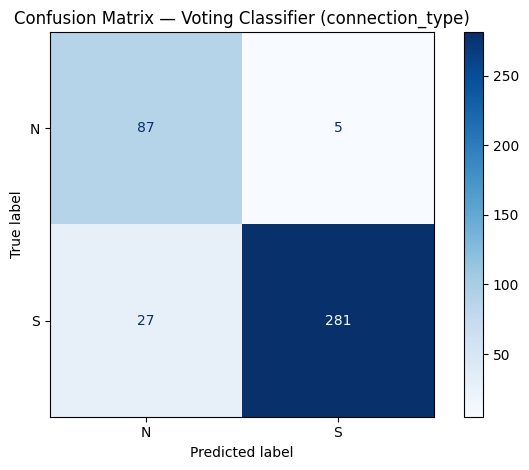

In [114]:
# %%
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

y = df["connection_type"]
X = df[["port", "preauth", "Hour", "conn_per_hour"]].copy()

num_cols  = ["port", "Hour", "conn_per_hour"]
bool_cols = ["preauth"]

# pipeline numérique : imputer puis scaler
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("bool", "passthrough", bool_cols),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.20, random_state=42
)

# Modèles de base
lr = LogisticRegression(max_iter=500)
svm = LinearSVC()

bagging = BaggingClassifier(
    estimator=LogisticRegression(max_iter=500),  # <-- plus base_estimator
    n_estimators=10,
    random_state=42,
    n_jobs=-1
)

voting = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", VotingClassifier(
        estimators=[
            ("lr", lr),
            ("svm", svm),
            ("bagging", bagging)
        ],
        voting="hard",
        n_jobs=-1
    ))
])

# Entraînement
voting.fit(X_train, y_train)

# Prédiction
y_pred = voting.predict(X_test)

print("=== Voting Classifier — connection_type ===")
print(classification_report(y_test, y_pred, digits=3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Confusion Matrix — Voting Classifier (connection_type)")
plt.tight_layout()
plt.show()


On obtient les meme resultats qu'avec la regression linéaire car notre data set est plutot petit/ simple et les colonnes sont deja tres discriminantes, il est donc difficile d'obtenir de meilleurs resultats.
De plus LogisticRegression est déjà stable, donc faire du Bagging dessus n’améliore pas forcément la performance, juste la variance.

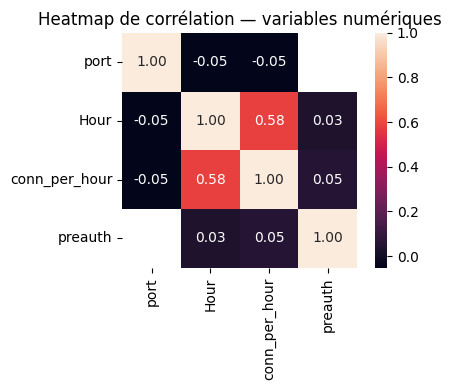

In [115]:
import seaborn as sns

corr_df = df[["port", "Hour", "conn_per_hour", "preauth"]].copy()

# convertir le bool en int pour la corrélation
if corr_df["preauth"].dtype == bool:
    corr_df["preauth"] = corr_df["preauth"].astype(int)

plt.figure(figsize=(5,4))
sns.heatmap(corr_df.corr(), annot=True, fmt=".2f", square=True)
plt.title("Heatmap de corrélation — variables numériques")
plt.tight_layout()
plt.show()


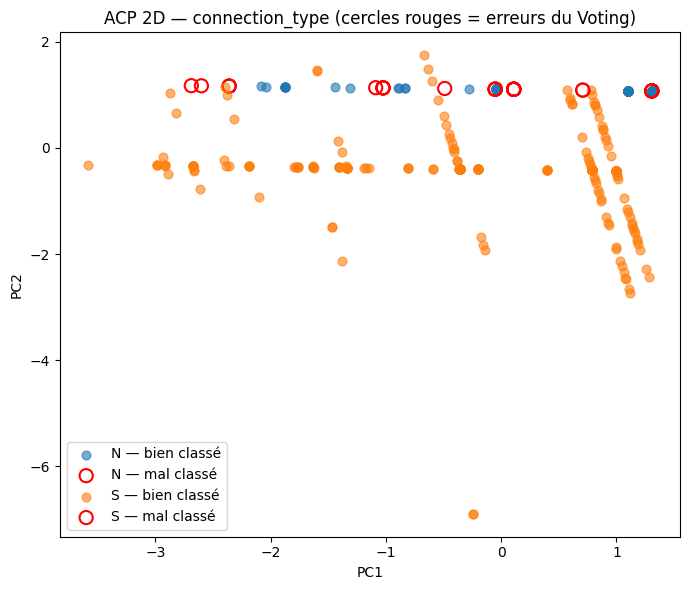

In [116]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

# On repart du même X_test / y_test / y_pred que l'ensemble Voting
X_test_num = X_test[["port", "Hour", "conn_per_hour", "preauth"]].copy()

# convertir le booléen en 0/1 si besoin
if X_test_num["preauth"].dtype == bool:
    X_test_num["preauth"] = X_test_num["preauth"].astype(int)

# 1) Imputation des NaN
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X_test_num)

# 2) Standardisation
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X_imputed)

# 3) PCA 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

misclassified = (y_test != y_pred)

plt.figure(figsize=(7,6))

classes = sorted(y_test.unique())
colors = ["tab:blue", "tab:orange"]

for label, color in zip(classes, colors):
    mask = (y_test == label)

    # bien classés
    plt.scatter(
        X_pca[mask & ~misclassified, 0],
        X_pca[mask & ~misclassified, 1],
        alpha=0.6,
        s=40,
        label=f"{label} — bien classé"
    )

    # mal classés
    plt.scatter(
        X_pca[mask & misclassified, 0],
        X_pca[mask & misclassified, 1],
        facecolors="none",
        edgecolors="red",
        s=90,
        linewidths=1.5,
        label=f"{label} — mal classé"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("ACP 2D — connection_type (cercles rouges = erreurs du Voting)")
plt.legend()
plt.tight_layout()
plt.show()


=== Decision Tree — connection_type ===
              precision    recall  f1-score   support

           N      1.000     0.859     0.924        92
           S      0.960     1.000     0.979       308

    accuracy                          0.968       400
   macro avg      0.980     0.929     0.952       400
weighted avg      0.969     0.968     0.967       400



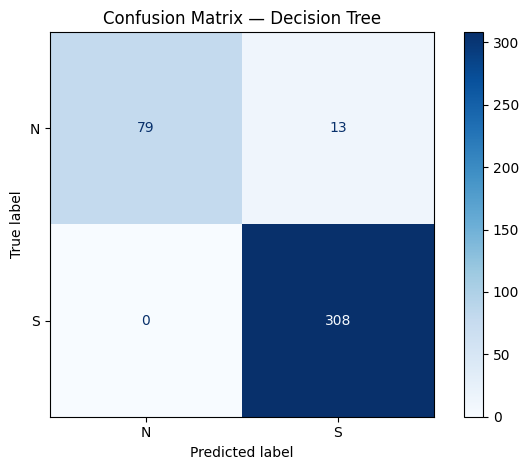

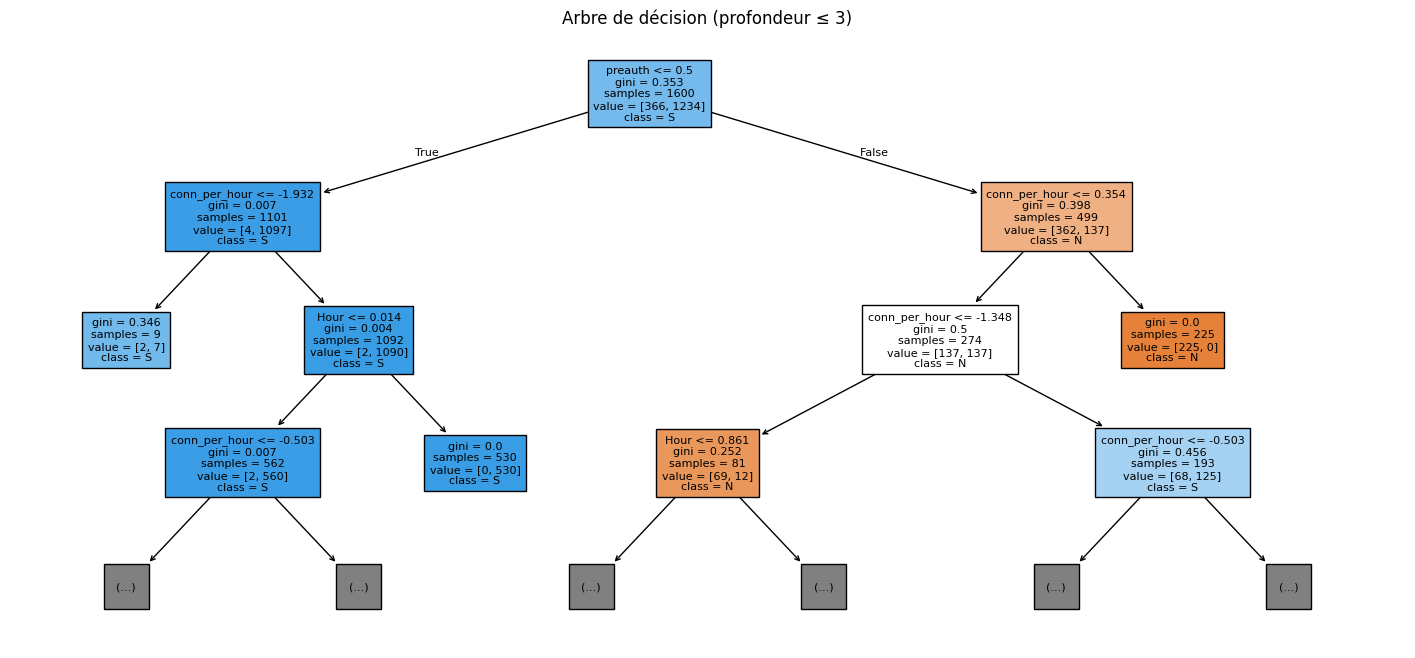

In [117]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", DecisionTreeClassifier(
        max_depth=5,
        min_samples_leaf=5,
        random_state=42
    ))
])

tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

print("=== Decision Tree — connection_type ===")
print(classification_report(y_test, y_pred_tree, digits=3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tree, cmap="Blues")
plt.title("Confusion Matrix — Decision Tree")
plt.tight_layout()
plt.show()

plt.figure(figsize=(18,8))
feature_names = ["port", "Hour", "conn_per_hour", "preauth"]
plot_tree(
    tree_clf.named_steps["clf"],
    feature_names=feature_names,
    class_names=[str(c) for c in tree_clf.classes_],
    filled=True,
    max_depth=3,
    fontsize=8
)
plt.title("Arbre de décision (profondeur ≤ 3)")
plt.show()


=== Random Forest — connection_type ===
              precision    recall  f1-score   support

           N      0.910     0.989     0.948        92
           S      0.997     0.971     0.984       308

    accuracy                          0.975       400
   macro avg      0.953     0.980     0.966       400
weighted avg      0.977     0.975     0.975       400



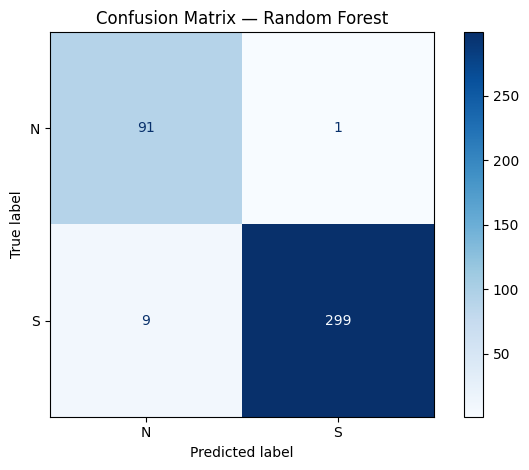

In [118]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_leaf=3,
        n_jobs=-1,
        random_state=42
    ))
])

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("=== Random Forest — connection_type ===")
print(classification_report(y_test, y_pred_rf, digits=3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap="Blues")
plt.title("Confusion Matrix — Random Forest")
plt.tight_layout()
plt.show()


=== Gradient Boosting — connection_type ===
              precision    recall  f1-score   support

           N      0.910     0.989     0.948        92
           S      0.997     0.971     0.984       308

    accuracy                          0.975       400
   macro avg      0.953     0.980     0.966       400
weighted avg      0.977     0.975     0.975       400



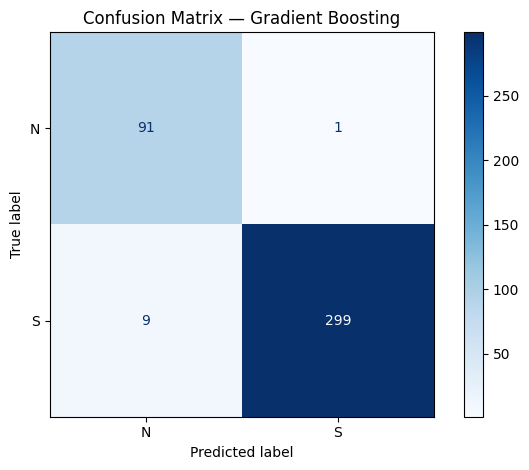

In [119]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", GradientBoostingClassifier(random_state=42))
])

gb_clf.fit(X_train, y_train)
y_pred_gb = gb_clf.predict(X_test)

print("=== Gradient Boosting — connection_type ===")
print(classification_report(y_test, y_pred_gb, digits=3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb, cmap="Blues")
plt.title("Confusion Matrix — Gradient Boosting")
plt.tight_layout()
plt.show()
